In [1]:
%load_ext autoreload
%autoreload 2

import IPython
from pathlib import Path
import os
locals = IPython.extract_module_locals() # type: ignore
notebook_name = "/".join(locals[1]["__vsc_ipynb_file__"].split("/"))
os.chdir(Path(notebook_name).parent.parent)

In [18]:
from typing import Callable, Any
from pathlib import Path
from dataclasses import dataclass, field
from functools import partial

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from retail_recommender_system.models.mf import MF, MFDataset, MFEvalDataset,recommend_udf, collate_fn, eval_collate_fn 
from retail_recommender_system.evaluation.prediction import recommend_k
from retail_recommender_system.evaluation.metrics import precision_k, recall_k
from retail_recommender_system.utils import load_model, save_model, plot_epoch_metrics

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
relations = pl.read_parquet(".data/intermediate/relations.parquet")
relations_filtered = pl.read_parquet(".data/intermediate/relations_filtered.parquet")
users = pl.read_parquet(".data/intermediate/users.parquet")
items = pl.read_parquet(".data/intermediate/articles.parquet")

relations = relations_filtered

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/retail_recommender_system/retail_recommender_system/utils.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


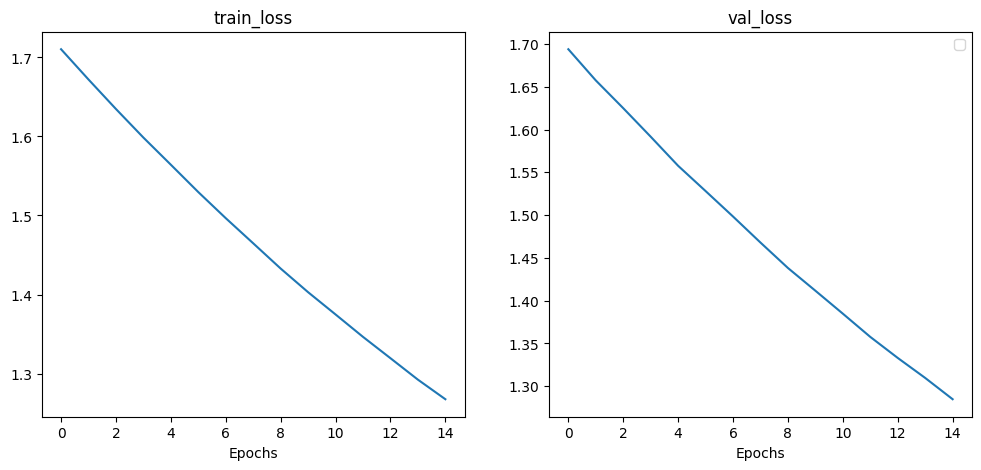

In [17]:
plot_epoch_metrics(train_loss=history.train_loss, val_loss=history.val_loss)

In [19]:
K = 5
users_set = torch.from_numpy(X_valid.select("customer_id_map").unique().sort(by="customer_id_map").to_numpy().flatten()).to(torch.int32)
items_set = torch.from_numpy(X_valid.select("article_id_map").unique().sort(by="article_id_map").to_numpy().flatten()).to(torch.int32)
loader = DataLoader(
    MFEvalDataset(users_set, items_set, user_batch_size=1024), 
    batch_size=1,
    collate_fn=eval_collate_fn,
    shuffle=False
)

In [20]:
ground_truth = torch.from_numpy(
    (
        X_valid
        .select("customer_id_map", "article_id_map").to_numpy()
    )
).to(torch.int32).T

In [21]:
recommendations = recommend_k(partial(recommend_udf, model=model, n_items=len(items_set)), loader, K, past_interactions=None)
precision = precision_k(recommendations, ground_truth, k=K, users_idx=users_set, n_users=n_users, n_items=n_items) 
recall = recall_k(recommendations, ground_truth, k=K, users_idx=users_set, n_users=n_users, n_items=n_items)
print(f"Model epoch: {0} - Precision@{K}: {precision:.7f} - Recall@{K}: {recall:.7f}")

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]

torch.Size([102022, 5]) torch.Size([102022]) torch.Size([102022])
Model epoch: 0 - Precision@5: 0.0000451 - Recall@5: 0.0000310


In [22]:
model_base = MF(**model_config)
recommendations = recommend_k(partial(recommend_udf, model=model_base, n_items=len(items_set)), loader, K, past_interactions=None)
precision = precision_k(recommendations, ground_truth, k=K, users_idx=users_set, n_users=n_users, n_items=n_items) 
recall = recall_k(recommendations, ground_truth, k=K, users_idx=users_set, n_users=n_users, n_items=n_items)
print(f"Model epoch: {0} - Precision@{K}: {precision:.7f} - Recall@{K}: {recall:.7f}")

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

torch.Size([102022, 5]) torch.Size([102022]) torch.Size([102022])
Model epoch: 0 - Precision@5: 0.0000470 - Recall@5: 0.0000337


In [24]:
for i in range(1, EPOCHS + 1):
    m = load_model(MF, Path(f".models/mf_{i}.pth"), model_config)
    recommendations = recommend_k(partial(recommend_udf, model=m, n_items=len(items_set)), loader, K, past_interactions=None)
    precision = precision_k(recommendations, ground_truth, k=K, users_idx=users_set, n_users=n_users, n_items=n_items) 
    recall = recall_k(recommendations, ground_truth, k=K, users_idx=users_set, n_users=n_users, n_items=n_items)
    print(f"Model epoch: {i} - Precision@{K}: {precision:.7f} - Recall@{K}: {recall:.7f}")

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Model epoch: 1 - Precision@5: 0.0000608 - Recall@5: 0.0000426


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


Model epoch: 2 - Precision@5: 0.0000588 - Recall@5: 0.0000422


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


Model epoch: 3 - Precision@5: 0.0000549 - Recall@5: 0.0000363


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Model epoch: 4 - Precision@5: 0.0000588 - Recall@5: 0.0000387


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Model epoch: 5 - Precision@5: 0.0000529 - Recall@5: 0.0000361


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Model epoch: 6 - Precision@5: 0.0000529 - Recall@5: 0.0000351


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Model epoch: 7 - Precision@5: 0.0000510 - Recall@5: 0.0000325


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Model epoch: 8 - Precision@5: 0.0000510 - Recall@5: 0.0000325


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


Model epoch: 9 - Precision@5: 0.0000510 - Recall@5: 0.0000325


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Model epoch: 10 - Precision@5: 0.0000510 - Recall@5: 0.0000325


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


Model epoch: 11 - Precision@5: 0.0000510 - Recall@5: 0.0000325


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


Model epoch: 12 - Precision@5: 0.0000490 - Recall@5: 0.0000318


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Model epoch: 13 - Precision@5: 0.0000451 - Recall@5: 0.0000310


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Model epoch: 14 - Precision@5: 0.0000451 - Recall@5: 0.0000310


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]

Model epoch: 15 - Precision@5: 0.0000451 - Recall@5: 0.0000310
